# Coding GPT-2 LLM architecture

What you will learn:
    
    ** DummyGPT Model architecture
        Token Embedding
        Positional Embedding
        DumpyLayerNorm
        DummpyTransformerBlocks
        DummyDropout
        Dummpy Final Head or prediction head
    
    Layer Normalization
        Nomalization(zero mean, and unit variance) of Batch data on the last dimenssion the embedding dimenssion
        scaling and shifting of out_norm (trainable parameters)
        
    GELU
    
    FeedForward Layer and shortcut connections:
        linear layer (nn.linear)
        GELU
    
    Mask - Multihead - Attention
        self-attention
            X -> WQ, WK, WV - > Q,K,V(query searches for relevant keys) - > Context_vector - > softmax.K - out
        
        Multi head attention:
            The only difference is the WQ,WK,WV(batch, num_tokens, d_out), d_out = out_emd*num_heads 
            
        MaskMultihead attention:
            Mask the Q.K matrix to zero above the diagonal, so that past words has no effect on the future words
        
    
    TransformerBlock:
        shortcut = x
        x = LayerNorm(x)
        x = MultiheadAttention(x)
        x = Dropout(x)
        x = x + shortcut
        
        shortcut = x
        x = LayerNorm(x)
        x = FeedForward(x)
        x = Dropout(x)
        x = shortcut + x
        
    
    GPT2 model:
        TokEmedding
        PosEmbedding
        Dropout
        TransformerBlocks(x12,x24,x36,x48)
        LayerNorm
        Final_linear_layer
        
    How Calculate the model paramters
    How to calculat the model size 
        

In [3]:
GPT_CONFIG_124M = {
    'vocab_size':50257,
    'context_length': 1024,
    'emb_dim': 786,
    'n_layers': 12,
    'n_heads': 12,
    'drop_rate': 0.1,
    'qkv_bias': False        
}

# DummyGPT Model

In [4]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
             for _ in range(cfg['n_layers'])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'], cfg['vocab_size'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x  = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [5]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, emb_dim, vocab_size):
        super().__init__()
        
    def forward(self, x):
        return x

In [6]:
!pip install tiktoken==0.7.0

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
txt1 = 'Palwasha is my daughter'
txt2 = 'Palwasha is a girl'
batch = []

ids1 = tokenizer.encode(txt1)
ids2 = tokenizer.encode(txt2)
batch.append(torch.tensor(ids1))
batch.append(torch.tensor(ids2))
batch = torch.stack(batch, dim=0)

print(batch)


ConnectionError: HTTPSConnectionPool(host='openaipublic.blob.core.windows.net', port=443): Max retries exceeded with url: /gpt-2/encodings/main/vocab.bpe (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa0f25f7850>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [ ]:
torch.manual_seed(123)
dgpt = DummyGPTModel(GPT_CONFIG_124M)

In [8]:
logits = dgpt(batch)

NameError: name 'dgpt' is not defined

In [80]:
print(logits.shape)
print(logits)

torch.Size([2, 6, 50257])
tensor([[[-0.9009, -0.3462, -1.1963,  ..., -0.7285,  1.1796, -0.0895],
         [-0.8803,  1.4735, -0.5708,  ..., -0.3976, -1.3149,  0.7172],
         [-1.5275, -0.3589, -0.2127,  ..., -0.1332,  0.1266,  1.9788],
         [ 1.2329,  0.4018, -0.3821,  ...,  0.5119,  0.4435,  0.4486],
         [ 1.2599, -0.2800, -2.1052,  ...,  0.1005, -0.2556, -1.1580],
         [ 0.9682,  0.5080,  0.1177,  ..., -0.5501,  0.8246, -0.9310]],

        [[-0.7734, -0.5588, -0.6483,  ..., -1.5100,  1.3543,  0.0924],
         [-0.8405,  0.8856, -0.8034,  ...,  0.0793, -1.0281,  1.4663],
         [-1.5577, -0.2812, -0.8740,  ..., -0.4292, -0.0373,  2.4763],
         [ 1.1661,  0.3346, -0.4415,  ...,  0.6666,  0.4709,  0.6340],
         [ 0.9187, -0.1523, -0.0169,  ...,  0.8237,  0.8166, -1.5907],
         [ 0.5480,  0.5880,  0.7853,  ..., -0.1168, -0.0947, -0.6201]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalization

In [81]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)

In [82]:
out.shape
# print(out)

torch.Size([2, 6])

In [83]:
mean = out.mean(dim = -1, keepdim=True)
var = out.var(dim = -1, keepdim=True)

print(f'Mean:  {mean.shape}')
print(f'Variance: {var.shape}')

Mean:  torch.Size([2, 1])
Variance: torch.Size([2, 1])


In [84]:
# torch.set_printoptions(sci_mode=False)
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(f'mean: {mean} var: {var}')

mean: tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>) var: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [85]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim= -1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [86]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)


In [87]:
print(f'mean: {out_ln.mean(dim=-1, keepdim=True)} var: {out_ln.var(dim=-1, keepdim=True, unbiased=False)}')

mean: tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>) var: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU Activation function

In [88]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))
        

In [89]:
gelu = GELU()
out = gelu(out_ln)

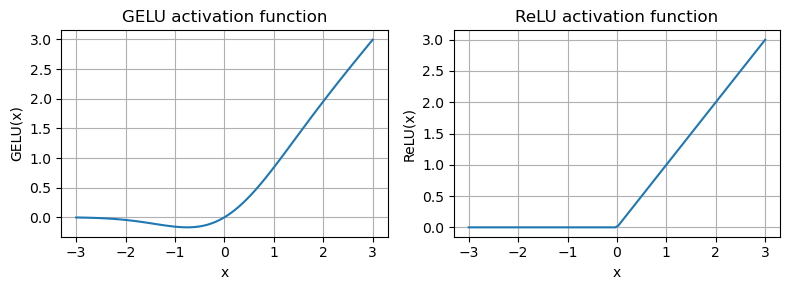

In [90]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
class FeedForward(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_out)
        self.gelu = GELU()
        #self.fc2 = nn.Linear(4*emb_dim, emb_dim)
    def forward(self, x):
        return self.gelu(self.fc1(x))

In [92]:
batch = torch.rand(2,3,786)
ffn = FeedForward(GPT_CONFIG_124M['emb_dim'],GPT_CONFIG_124M['emb_dim'])
out = ffn(batch)
out.shape

torch.Size([2, 3, 786])

In [93]:
class ResidualNetwork(nn.Module):
    def __init__(self,cfg,  layer_dims, num_layers, short_cut=True):
        super().__init__()
        self.short_cut = short_cut
    #self.ffn = FeedForward(cfg['emb_dim'])
        self.layers = nn.ModuleList([FeedForward(layer_dims[i], layer_dims[i+1]) for i in range(0,num_layers-1)])

    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.short_cut:
                layer_out = x + layer_out
            x = layer_out
        return x

In [94]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
rn = ResidualNetwork(GPT_CONFIG_124M, layer_sizes, 6)
out = rn(sample_input)

In [95]:
out.shape


torch.Size([1, 3])

In [96]:
def print_gradients(model, x):
    out = model(x)
    target = torch.tensor([0.])
    loss = nn.MSELoss()
    loss = loss(out, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [97]:
rn = ResidualNetwork(GPT_CONFIG_124M, layer_sizes, 6, short_cut=False)
print_gradients(rn, sample_input)

layers.0.fc1.weight has gradient mean of 0.0003279339289292693
layers.1.fc1.weight has gradient mean of 0.00030065476312302053
layers.2.fc1.weight has gradient mean of 0.000655296491459012
layers.3.fc1.weight has gradient mean of 0.002097164746373892
layers.4.fc1.weight has gradient mean of 0.008189782500267029


In [98]:
rn = ResidualNetwork(GPT_CONFIG_124M, layer_sizes, 6, short_cut=True)
print_gradients(rn, sample_input, )

layers.0.fc1.weight has gradient mean of 1.1383100748062134
layers.1.fc1.weight has gradient mean of 0.9859948754310608
layers.2.fc1.weight has gradient mean of 1.0475314855575562
layers.3.fc1.weight has gradient mean of 0.780488908290863
layers.4.fc1.weight has gradient mean of 2.668015480041504


In [145]:
GPT_CONFIG_124M = {
    'vocab_size':50257,
    'context_length': 4,
    'emb_dim': 768,
    'n_layers': 12,
    'n_heads': 12,
    'drop_rate': 0.1,
    'qkv_bias': False        
}

In [146]:
import torch
import torch.nn as nn

class MaskMultiHeadAttention(nn.Module):
    def __init__(self,d_in, d_out, context_length ,num_heads, dropout=0.5, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = self.d_out // num_heads

        self.W_Q = nn.Linear(d_in, d_out, qkv_bias)
        self.W_K = nn.Linear(d_in, d_out, qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, qkv_bias)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)

        )

        self.projection = nn.Linear(self.d_out, self.d_out)

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        Q = Q.view(b, num_tokens, self.num_heads, self.head_dim)
        K = K.view(b, num_tokens, self.num_heads, self.head_dim)
        V = V.view(b, num_tokens, self.num_heads, self.head_dim)

        Q = Q.transpose(1,2)
        K = K.transpose(1,2)
        V = V.transpose(1,2)

        attn_score = Q @ K.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_score.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
                        attn_score/K.shape[-1]**0.5, dim=-1)
        
        context_vec = self.dropout(attn_weights)
        context_vec = (attn_weights @ V).transpose(1,2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        #print(context_vec)

        out = self.projection(context_vec)

        return out
    

class LayerNorm(nn.Module):
    def __init__(self, cfg, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(cfg['emb_dim']))
        self.shift = nn.Parameter(torch.zeros(cfg['emb_dim']))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        out_norm = (x - mean)/ torch.sqrt(var +  self.eps)
        return self.scale*out_norm + self.shift
    

class GELU(nn.Module):
    def __init__(self,):
        super().__init__()
    
    def forward(self, x):

        return 0.8 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))

        ))
    
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim'])
        self.gelu = GELU()
        self.fc2 = nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layer_norm1 = LayerNorm(cfg)
        self.layer_norm2 = LayerNorm(cfg)

        self.mmhatt = MaskMultiHeadAttention(
                                          d_in = cfg['emb_dim'],
                                          d_out = cfg['emb_dim'],
                                          context_length = cfg['context_length'],
                                          num_heads = cfg['n_heads'],
                                          dropout = cfg['drop_rate'],
                                          qkv_bias = cfg['qkv_bias']
                                         )
        self.ff = FeedForward(cfg)
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.layer_norm1(x)
        x = self.mmhatt(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.layer_norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [147]:
# # from blocks.maskmultiheadattention import MaskMultiHeadAttention,LayerNorm, FeedForward

# class TransformerBlock(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.layer_norm1 = LayerNorm(cfg)
#         self.layer_norm2 = LayerNorm(cfg)

#         self.mmhatt = MaskMultiHeadAttention(
#                                           d_in = cfg['emb_dim'],
#                                           d_out = cfg['emb_dim'],
#                                           context_length = cfg['context_length'],
#                                           num_heads = cfg['n_heads'],
#                                           # num_layers = cfg['n_layers'],
#                                           dropout = cfg['drop_rate'],
#                                           qkv_bias = cfg['qkv_bias']
#                                          )
#         self.ff = FeedForward(cfg)
#         self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

#     def forward(self, x):
#         shortcut = x
#         x = self.layer_norm1(x)
#         x = self.mmhatt(x)
#         x = self.drop_shortcut(x)
#         x = x + shortcut

#         shortcut = x
#         x = self.layer_norm2(x)
#         x = self.ff(x)
#         x = self.drop_shortcut(x)
#         x = x + shortcut
#         return x
        
        
        

In [148]:
# batch = torch.rand(2,3,786)
# trf = TransformerBlock(GPT_CONFIG_124M)

In [149]:
# ln = LayerNorm(GPT_CONFIG_124M)
# out = ln(batch)
# print(out.shape)
# out = trf(batch)
# out.shape

In [150]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.final_norm = LayerNorm(cfg)
        self.final_linear_layer = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) 
             for _ in range(cfg['n_layers'])]
        )
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        token_embeddings = self.tok_emb(input_ids)
        positional_embeddings = self.pos_emb(
            torch.arange(seq_len, device=input_ids.device))
        
        input_embeddings = token_embeddings + positional_embeddings
        x = self.dropout(input_embeddings)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.final_linear_layer(x)
        return logits
        
        

In [172]:
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset

class GPTDataset(Dataset):
    def __init__(self, text, context_len, stride):
        super().__init__()
        tokenizer = tiktoken.get_encoding('gpt2')
        # print(tokenizer.vocab)
        ids = tokenizer.encode(text)
        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(ids)-context_len, stride):
            input_id = ids[i:i+context_len]
            target_id = ids[i+1:i+context_len+1]
            self.input_ids.append(torch.tensor(input_id))
            self.target_ids.append(torch.tensor(target_id))
        # self.input_ids, self.target_ids
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

    def __len__(self, ):
        return len(self.input_ids)

In [173]:
from torch.utils.data import DataLoader
with open('the-verdict.txt', 'r') as f:
    text_data = f.read()

dataset = GPTDataset(text_data, GPT_CONFIG_124M['context_length'], 200)

dataloader  = DataLoader(dataset, batch_size=1, shuffle=True, )


AttributeError: 'Encoding' object has no attribute 'vocab'

In [194]:
gpt = GPTModel(GPT_CONFIG_124M)
#for in_ids, out_ids in dataloader:




I am shah attackers elig Kuwait lowered linguisticAfrican Cannes capit ES Moj


In [ ]:
result = generate_sample_text(GPT_CONFIG_124M)
text = tokenizer.decode(result.squeeze(0).tolist())
print(text)

In [195]:
total_parameters = sum(p.numel() for p in gpt.parameters())
print(f'Total Number of Parameters: {total_parameters}')

Total Number of Parameters: 162226176


In [140]:
print(gpt.tok_emb.weight.shape)
print(gpt.pos_emb.weight.shape)

torch.Size([50257, 768])
torch.Size([1024, 768])


In [141]:
total_params_gpt2 = (
total_parameters - sum(p.numel()
for p in gpt.final_linear_layer.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [144]:
size_bytes = total_parameters*4
size_megabytes = size_bytes/(1024*1024)
print(f'The size of GPT2 model {size_megabytes:.2f} mb')

The size of GPT2 model 621.83 mb
